# Modèle linéaire de prédiction

### Librairies

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from datetime import datetime

from lib.dataeng import Etl

import seaborn as sns

from tqdm import tqdm

2024-02-28 19:19:11.212823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Sourcing Data

In [2]:
etl = Etl()

df_weight_raw, df_food_raw, df_exos_raw, df_all = etl.extract_store_all()


Le fichier poids le plus récent est : data_BEN_1709103824.zip, parmi :
data_BEN_1709012531.zip
data_BEN_1709103824.zip

Le fichier food le plus récent est : File-Export-2020-08-03-to-2024-02-28.zip, parmi
File-Export-2020-08-03-to-2024-02-27.zip
File-Export-2020-08-03-to-2024-02-28.zip

Le fichier exercices le plus récent est : polar-user-data-export_bd8a06c1-7cac-47fc-a1fe-71b374e61732.zip, parmi :
polar-user-data-export_bd8a06c1-7cac-47fc-a1fe-71b374e61732.zip
polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip


100%|██████████| 1924/1924 [01:21<00:00, 23.71it/s]


## Constitution Dataset

### Poids

In [3]:
df_weight_raw

,Date,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
0,2024-02-28,72.24,12.48,2.99,56.76,39.82,0.172757,1660.816
1,2024-02-28,71.86,12.28,2.98,56.58,39.68,0.170888,1656.928
2,2024-02-28,72.05,12.26,2.99,56.79,39.88,0.170160,1661.464
3,2024-02-28,72.02,12.24,2.99,56.77,39.87,0.169953,1661.248
4,2024-02-28,72.26,12.47,2.99,56.79,39.85,0.172571,1661.464
...,...,...,...,...,...,...,...,...
9378,2020-08-14,104.50,33.85,NaN,NaN,NaN,0.323923,1896.040
9379,2020-08-13,104.40,34.34,NaN,NaN,NaN,0.328927,1883.296
9380,2020-08-12,104.35,33.80,NaN,NaN,NaN,0.323910,1893.880
9381,2020-08-11,104.65,33.15,NaN,NaN,NaN,0.316770,1914.400


In [4]:
df_weight = df_weight_raw.groupby('Date').mean()  # récupère les valeurs quotidiennes moyennes

std_empiriques = df_weight_raw.groupby('Date').std().dropna()  # calcule les ecarts-types empiriques

In [5]:
df_weight_raw.groupby('Date').std().describe(include='all')

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
count,1253.000000,1253.000000,360.000000,360.000000,360.000000,1253.000000,1253.000000
mean,0.070500,0.086717,0.004775,0.068272,0.076295,0.001065,1.728411
std,0.046475,0.077229,0.003639,0.040015,0.058104,0.000782,1.668021
min,0.000000,0.000000,0.000000,0.009910,0.013887,0.000054,0.000000
25%,0.038397,0.054772,0.003780,0.052630,0.056376,0.000717,1.108426
50%,0.057009,0.074706,0.004880,0.066566,0.071601,0.000962,1.445902
75%,0.094868,0.096374,0.005345,0.079205,0.086522,0.001214,1.865620
max,0.588509,1.139576,0.063631,0.716210,1.072184,0.011172,24.415008


In [6]:
std_empiriques

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-03-04,0.036148,0.058992,0.004082,0.056716,0.066533,0.000812,1.264415
2023-03-05,0.092376,0.106369,0.000000,0.037353,0.053229,0.001281,0.821828
2023-03-06,0.023452,0.030496,0.000000,0.031937,0.040988,0.000427,0.787734
2023-03-07,0.018708,0.050067,0.000000,0.052026,0.072019,0.000706,1.255156
2023-03-08,0.042269,0.052313,0.004082,0.038297,0.064317,0.000674,0.893206
...,...,...,...,...,...,...,...
2024-02-24,0.148654,0.106480,0.005345,0.085496,0.083106,0.001207,1.886345
2024-02-25,0.147028,0.121941,0.002582,0.063230,0.061505,0.001370,1.431541
2024-02-26,0.125766,0.087413,0.004140,0.067422,0.064120,0.000962,1.481871


In [7]:
std_empiriques.describe(include='all')

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,0.102552,0.086090,0.004775,0.068272,0.076295,0.001033,1.561700
std,0.057132,0.028646,0.003639,0.040015,0.058104,0.000341,0.933077
min,0.011127,0.021931,0.000000,0.009910,0.013887,0.000292,0.282810
25%,0.047188,0.064340,0.003780,0.052630,0.056376,0.000797,1.190487
50%,0.112589,0.086143,0.004880,0.066566,0.071601,0.001022,1.529992
75%,0.136672,0.104647,0.005345,0.079205,0.086522,0.001229,1.804876
max,0.588509,0.195337,0.063631,0.716210,1.072184,0.003612,16.816833


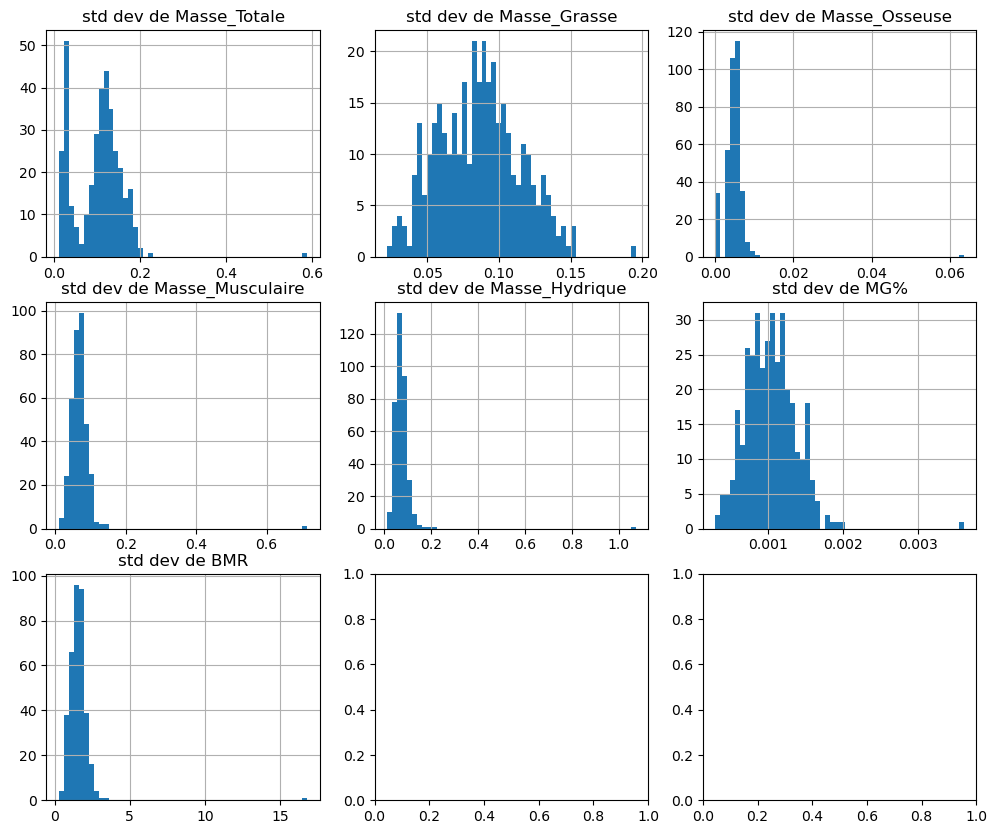

In [8]:
fig, axs = plt.subplots(nrows=len(std_empiriques.columns)//3+1, ncols=3, figsize=(12,10))
NBINS = 50

for i, name in enumerate(std_empiriques.columns):
    r = i//3
    c = i%3
    x = std_empiriques[name].to_numpy()
    axs[r,c].hist(x, bins=NBINS)
    axs[r,c].set_title(f'std dev de {name}')
    axs[r,c].grid(True)

plt.show()

In [9]:
df_weight

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2020-08-09,107.250000,37.190000,NaN,NaN,NaN,0.346760,1883.2960
2020-08-11,104.650000,33.150000,NaN,NaN,NaN,0.316770,1914.4000
2020-08-12,104.350000,33.800000,NaN,NaN,NaN,0.323910,1893.8800
2020-08-13,104.400000,34.340000,NaN,NaN,NaN,0.328927,1883.2960
2020-08-14,104.500000,33.850000,NaN,NaN,NaN,0.323923,1896.0400
...,...,...,...,...,...,...,...
2024-02-24,72.105333,12.296667,2.990000,56.803333,39.890667,0.170536,1661.8672
2024-02-25,73.082000,12.451333,3.029333,57.584667,40.636000,0.170373,1679.6224
2024-02-26,72.678000,12.398667,3.012000,57.252000,40.314000,0.170596,1672.0336


### Food

In [10]:
df_food_raw

,Date,Meal,Calories,Lipides,Glucides,Proteines
0,2020-08-03,Breakfast,621.4,27.9,69.7,22.4
1,2020-08-03,Dinner,581.6,20.4,84.5,17.1
2,2020-08-03,Lunch,656.0,41.4,26.6,33.5
3,2020-08-03,Snacks,58.0,0.0,14.0,0.0
4,2020-08-04,Breakfast,1111.6,49.0,137.8,34.3
...,...,...,...,...,...,...
3785,2024-02-25,Lunch,734.7,19.3,72.8,67.5
3786,2024-02-26,Dinner,321.6,4.8,48.4,21.0
3787,2024-02-26,Lunch,1306.2,40.7,75.7,168.6
3788,2024-02-27,Dinner,609.1,15.4,88.6,34.0


In [11]:
df_food = df_food_raw.set_index(['Date','Meal']).unstack('Meal')

In [12]:
df_food.fillna(0, inplace=True)

In [13]:
df_food.columns = df_food.columns.to_flat_index()

In [14]:
new_names = [ name[0] + '_' + name[1] for name in df_food.columns ]
df_food.columns = new_names

In [15]:
df_food.head(10)

,Calories_Breakfast,Calories_Dinner,Calories_Lunch,Calories_Snacks,Lipides_Breakfast,Lipides_Dinner,Lipides_Lunch,Lipides_Snacks,Glucides_Breakfast,Glucides_Dinner,Glucides_Lunch,Glucides_Snacks,Proteines_Breakfast,Proteines_Dinner,Proteines_Lunch,Proteines_Snacks
Date,,,,,,,,,,,,,,,,
2020-08-03,621.4,581.6,656.0,58.0,27.9,20.4,41.4,0.0,69.7,84.5,26.6,14.0,22.4,17.1,33.5,0.0
2020-08-04,1111.6,447.4,433.7,0.0,49.0,2.1,16.6,0.0,137.8,69.1,60.6,0.0,34.3,28.5,15.6,0.0
2020-08-05,1174.2,136.7,638.0,0.0,51.6,6.7,25.8,0.0,147.1,3.2,62.8,0.0,35.7,14.8,36.4,0.0
2020-08-06,747.0,801.3,388.9,0.0,35.3,15.5,15.6,0.0,81.4,22.6,30.3,0.0,25.8,11.8,22.4,0.0
2020-08-07,791.9,397.5,484.6,0.0,35.5,7.2,24.8,0.0,91.6,75.4,1.9,0.0,27.3,7.9,60.0,0.0
2020-08-08,714.5,359.8,499.3,383.1,29.8,19.8,22.7,19.3,85.6,3.4,38.5,1.6,26.4,40.0,26.7,14.7
2020-08-09,683.1,504.7,615.5,58.0,25.0,30.8,15.5,0.0,88.3,51.2,91.5,14.0,26.7,10.6,28.8,0.0
2020-08-10,646.8,604.6,214.0,0.0,21.0,10.0,11.8,0.0,88.3,107.8,11.1,0.0,26.7,20.7,14.9,0.0
2020-08-11,557.5,413.1,801.8,0.0,12.9,21.3,16.3,0.0,83.2,43.4,59.2,0.0,26.8,10.3,67.0,0.0


### Exercices

In [16]:
df_exos_raw

,exo_duree,exo_type,exo_cals_bruts
exo_date,,,
2021-03-29,3220.826,STRENGTH_TRAINING,328.0
2021-03-30,2818.678,RUNNING,449.0
2021-03-31,3186.236,STRENGTH_TRAINING,272.0
2021-04-01,0.000,0,0.0
2021-04-02,0.000,0,0.0
...,...,...,...
2024-02-23,2444.829,STRENGTH_TRAINING,233.0
2024-02-24,2345.655,WALKING,149.0
2024-02-25,6120.000,STRENGTH_TRAINING,649.0


In [17]:
df_exos_raw['exo_type'].value_counts()

STRENGTH_TRAINING       518
INDOOR_ROWING           325
0                       269
WALKING                 160
RUNNING                  22
JOGGING                  21
CROSS-COUNTRY_SKIING      6
BOXING                    4
DOWNHILL_SKIING           2
ROWING                    1
SWIMMING                  1
TREADMILL_RUNNING         1
Name: exo_type, dtype: int64

In [18]:
mask = df_exos_raw['exo_type']==0

df_exos_raw = df_exos_raw[~mask]

# df_exos_raw.describe(include='all')

# df_exos_raw

In [19]:
df_exos = df_exos_raw.groupby(['exo_date', 'exo_type']).sum()

In [20]:
df_exos = df_exos.unstack('exo_type')

In [21]:
df_exos.fillna(0, inplace=True)

In [22]:
df_exos.columns = df_exos.columns.to_flat_index()

In [23]:
new_names = [ name[1] + '_' + name[0] for name in df_exos.columns ]
df_exos.columns = new_names

In [24]:
df_exos

,BOXING_exo_duree,CROSS-COUNTRY_SKIING_exo_duree,DOWNHILL_SKIING_exo_duree,INDOOR_ROWING_exo_duree,JOGGING_exo_duree,ROWING_exo_duree,RUNNING_exo_duree,STRENGTH_TRAINING_exo_duree,SWIMMING_exo_duree,TREADMILL_RUNNING_exo_duree,...,CROSS-COUNTRY_SKIING_exo_cals_bruts,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts
exo_date,,,,,,,,,,,,,,,,,,,,,
2021-03-29,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3220.826,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,328.0,0.0,0.0,0.0
2021-03-30,0.0,0.0,0.0,0.0,0.000,0.0,2818.678,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,449.0,0.0,0.0,0.0,0.0
2021-03-31,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3186.236,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,272.0,0.0,0.0,0.0
2021-04-03,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3436.335,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,344.0,0.0,0.0,0.0
2021-04-04,0.0,0.0,0.0,0.0,2682.132,0.0,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,494.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3066.733,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,373.0,0.0,0.0,288.0
2024-02-23,0.0,0.0,0.0,0.0,0.000,0.0,0.000,2444.829,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,0.0,0.0
2024-02-24,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0


### Dataframe complète

In [25]:
df_all = pd.concat([df_weight, df_food, df_exos], axis=1).sort_index()

In [26]:
df_all.dropna(subset=['Masse_Totale', 'Masse_Grasse'], inplace=True)
df_all['Calories_Total'] = df_all['Calories_Breakfast'] + df_all['Calories_Dinner'] + df_all['Calories_Lunch'] + df_all['Calories_Snacks']
df_all

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2020-08-09,107.250000,37.190000,NaN,NaN,NaN,0.346760,1883.2960,683.1,504.7,615.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1861.3
2020-08-11,104.650000,33.150000,NaN,NaN,NaN,0.316770,1914.4000,557.5,413.1,801.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1772.4
2020-08-12,104.350000,33.800000,NaN,NaN,NaN,0.323910,1893.8800,690.1,563.3,640.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1894.3
2020-08-13,104.400000,34.340000,NaN,NaN,NaN,0.328927,1883.2960,723.0,541.3,558.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1822.6
2020-08-14,104.500000,33.850000,NaN,NaN,NaN,0.323923,1896.0400,723.0,637.9,530.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1891.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-24,72.105333,12.296667,2.990000,56.803333,39.890667,0.170536,1661.8672,442.7,398.8,1184.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0,2025.6
2024-02-25,73.082000,12.451333,3.029333,57.584667,40.636000,0.170373,1679.6224,606.0,627.4,734.7,...,0.0,0.0,0.0,0.0,0.0,649.0,0.0,0.0,0.0,1968.1
2024-02-26,72.678000,12.398667,3.012000,57.252000,40.314000,0.170596,1672.0336,0.0,321.6,1306.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1627.8
2024-02-27,72.660000,12.496667,3.007333,57.141333,40.192000,0.171987,1669.5280,0.0,609.1,1117.8,...,0.0,0.0,0.0,0.0,0.0,292.0,0.0,0.0,0.0,1726.9


### Construction d'une dataframe avec toutes les masses renseignées (ie depuis Mars 2023)

In [27]:
# df_all_masses est la Dataframe avec toutes les masses non NaN (depuis 2023)

df_all_masses = df_all.dropna(subset=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique'])  # drop les lignes où les masses Osseuse, Musculaire ou Hydrique sont NaN
df_all_masses.fillna(0, inplace=True)  # Met 0 dans les données d'exercice NaN
df_all_masses

/tmp/ipykernel_8314/2000915907.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_masses.fillna(0, inplace=True)  # Met 0 dans les données d'exercice NaN


,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2023-03-04,70.656667,11.420000,2.961667,56.258333,39.496667,0.161627,1649.512000,0.0,1329.2,941.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2271.1
2023-03-05,71.880000,11.848571,3.000000,57.014286,40.180000,0.164837,1666.678857,0.0,644.9,1129.4,...,0.0,0.0,0.0,0.0,0.0,443.0,0.0,0.0,0.0,1774.3
2023-03-06,71.030000,10.924000,3.010000,57.082000,40.476000,0.153794,1668.289600,0.0,968.1,791.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,614.0,1759.7
2023-03-07,72.185000,11.126667,3.060000,57.986667,41.366667,0.154141,1688.860000,968.5,1212.3,335.6,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,0.0,1016.0,2516.4
2023-03-08,72.283333,10.178333,3.131667,58.956667,42.821667,0.140811,1711.468000,986.9,0.0,672.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,1658.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-24,72.105333,12.296667,2.990000,56.803333,39.890667,0.170536,1661.867200,442.7,398.8,1184.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0,2025.6
2024-02-25,73.082000,12.451333,3.029333,57.584667,40.636000,0.170373,1679.622400,606.0,627.4,734.7,...,0.0,0.0,0.0,0.0,0.0,649.0,0.0,0.0,0.0,1968.1
2024-02-26,72.678000,12.398667,3.012000,57.252000,40.314000,0.170596,1672.033600,0.0,321.6,1306.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1627.8
2024-02-27,72.660000,12.496667,3.007333,57.141333,40.192000,0.171987,1669.528000,0.0,609.1,1117.8,...,0.0,0.0,0.0,0.0,0.0,292.0,0.0,0.0,0.0,1726.9


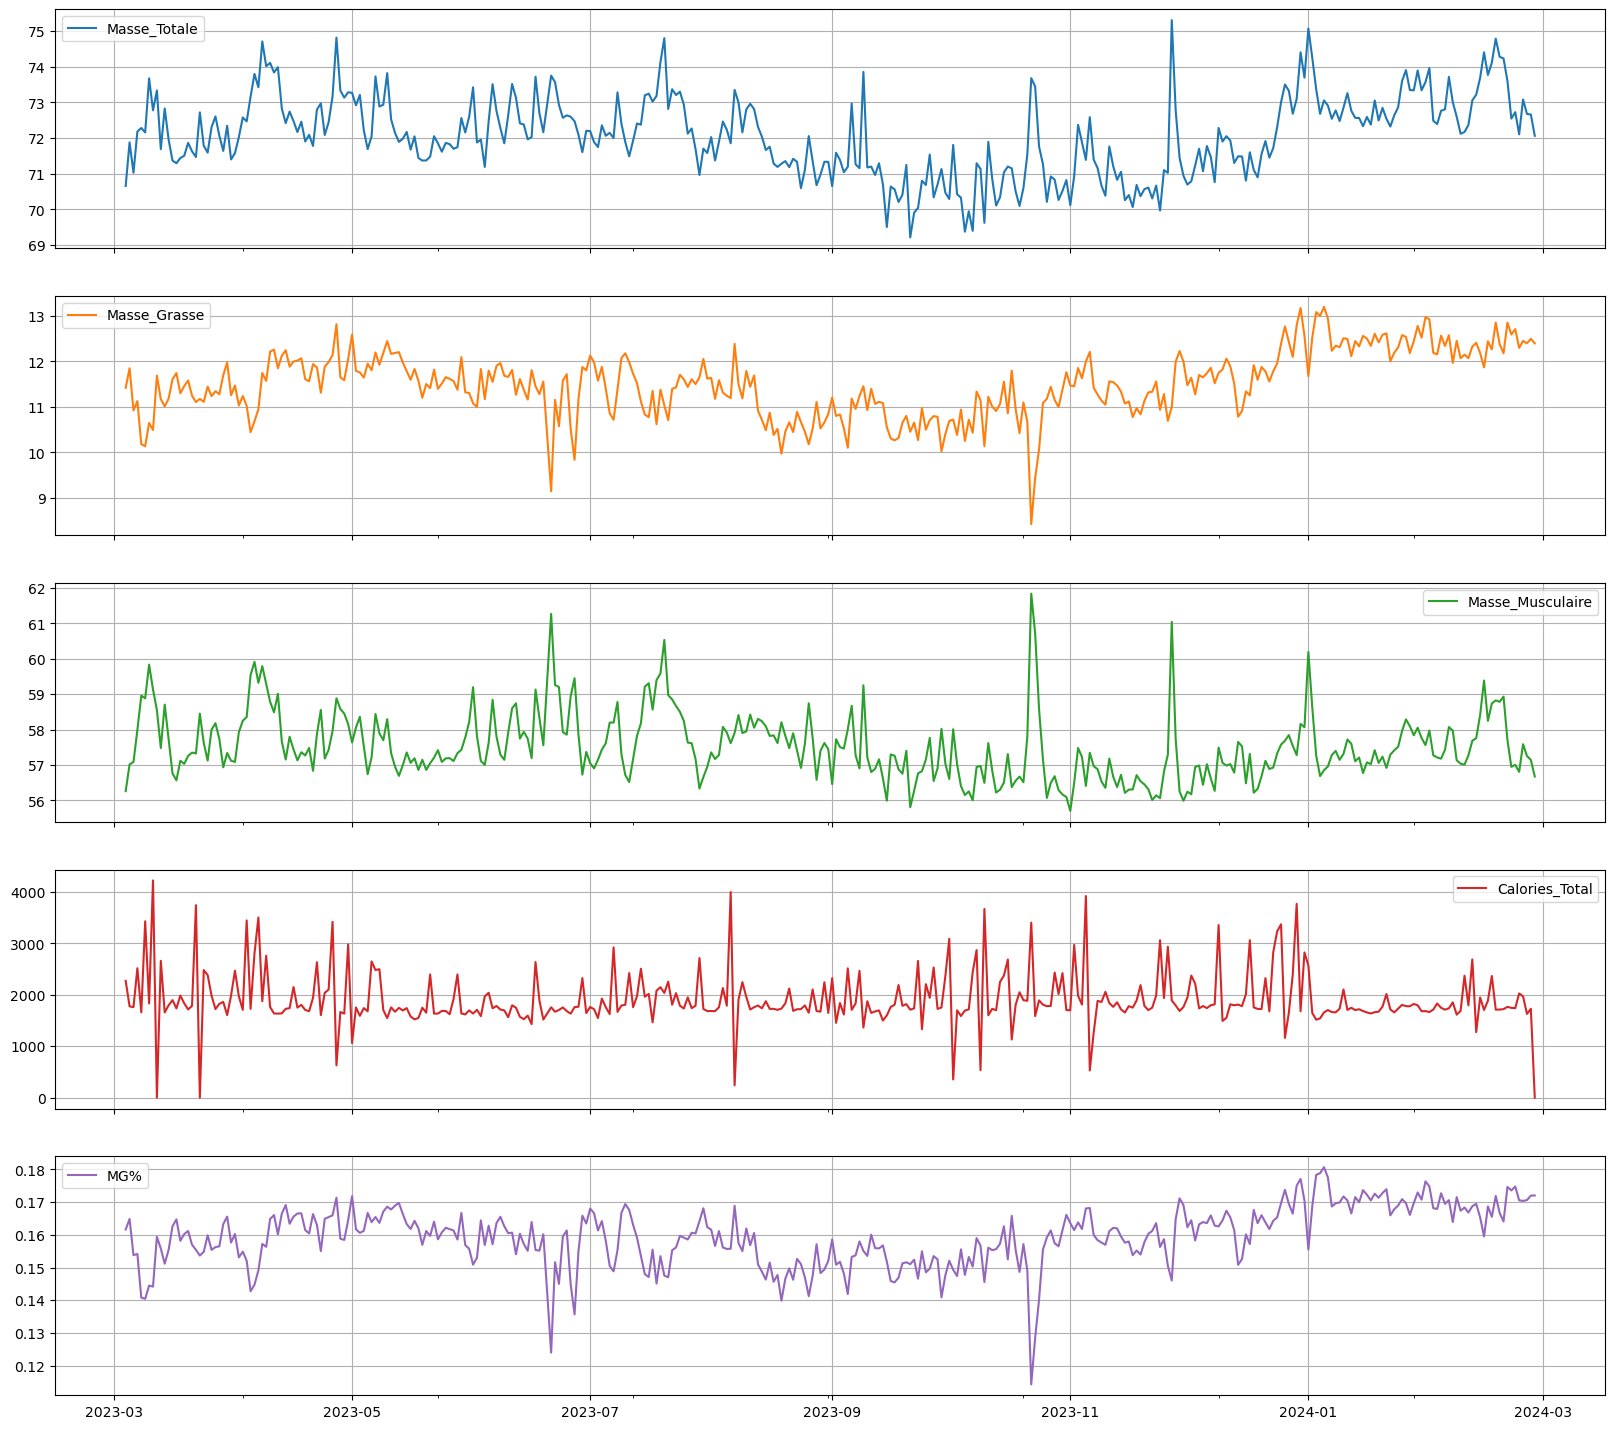

In [28]:
cols_to_display = ['Masse_Totale', 'Masse_Grasse', 'Masse_Musculaire', 'Calories_Total', 'MG%']

df_all_masses[cols_to_display].plot(subplots=True, figsize=(20,18), grid=True)
plt.show()

### Construction d'une autre dataframe avec juste masse totale et masse grasse (depuis Septembre 2020)

In [29]:
# df_mtmg_only est la dataframe avec les masses Totale et Grasse (depuis 2020)

df_mtmg_only = df_all.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique'])

In [30]:
df_mtmg_only.fillna(0, inplace=True)

In [31]:
# df_mtmg_only.dropna(inplace=True)
df_mtmg_only

,Masse_Totale,Masse_Grasse,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,Calories_Snacks,Lipides_Breakfast,Lipides_Dinner,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2020-08-09,107.250000,37.190000,0.346760,1883.2960,683.1,504.7,615.5,58.0,25.0,30.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1861.3
2020-08-11,104.650000,33.150000,0.316770,1914.4000,557.5,413.1,801.8,0.0,12.9,21.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1772.4
2020-08-12,104.350000,33.800000,0.323910,1893.8800,690.1,563.3,640.9,0.0,25.0,13.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1894.3
2020-08-13,104.400000,34.340000,0.328927,1883.2960,723.0,541.3,558.3,0.0,29.0,19.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1822.6
2020-08-14,104.500000,33.850000,0.323923,1896.0400,723.0,637.9,530.6,0.0,29.0,27.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1891.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-24,72.105333,12.296667,0.170536,1661.8672,442.7,398.8,1184.1,0.0,7.8,12.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0,2025.6
2024-02-25,73.082000,12.451333,0.170373,1679.6224,606.0,627.4,734.7,0.0,16.2,30.1,...,0.0,0.0,0.0,0.0,0.0,649.0,0.0,0.0,0.0,1968.1
2024-02-26,72.678000,12.398667,0.170596,1672.0336,0.0,321.6,1306.2,0.0,0.0,4.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1627.8
2024-02-27,72.660000,12.496667,0.171987,1669.5280,0.0,609.1,1117.8,0.0,0.0,15.4,...,0.0,0.0,0.0,0.0,0.0,292.0,0.0,0.0,0.0,1726.9


In [32]:
df_mtmg_only.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1282 entries, 2020-08-09 to 2024-02-28
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Masse_Totale                         1282 non-null   float64
 1   Masse_Grasse                         1282 non-null   float64
 2   MG%                                  1282 non-null   float64
 3   BMR                                  1282 non-null   float64
 4   Calories_Breakfast                   1282 non-null   float64
 5   Calories_Dinner                      1282 non-null   float64
 6   Calories_Lunch                       1282 non-null   float64
 7   Calories_Snacks                      1282 non-null   float64
 8   Lipides_Breakfast                    1282 non-null   float64
 9   Lipides_Dinner                       1282 non-null   float64
 10  Lipides_Lunch                        1282 non-null   float64
 11  Lipides_Snacks      

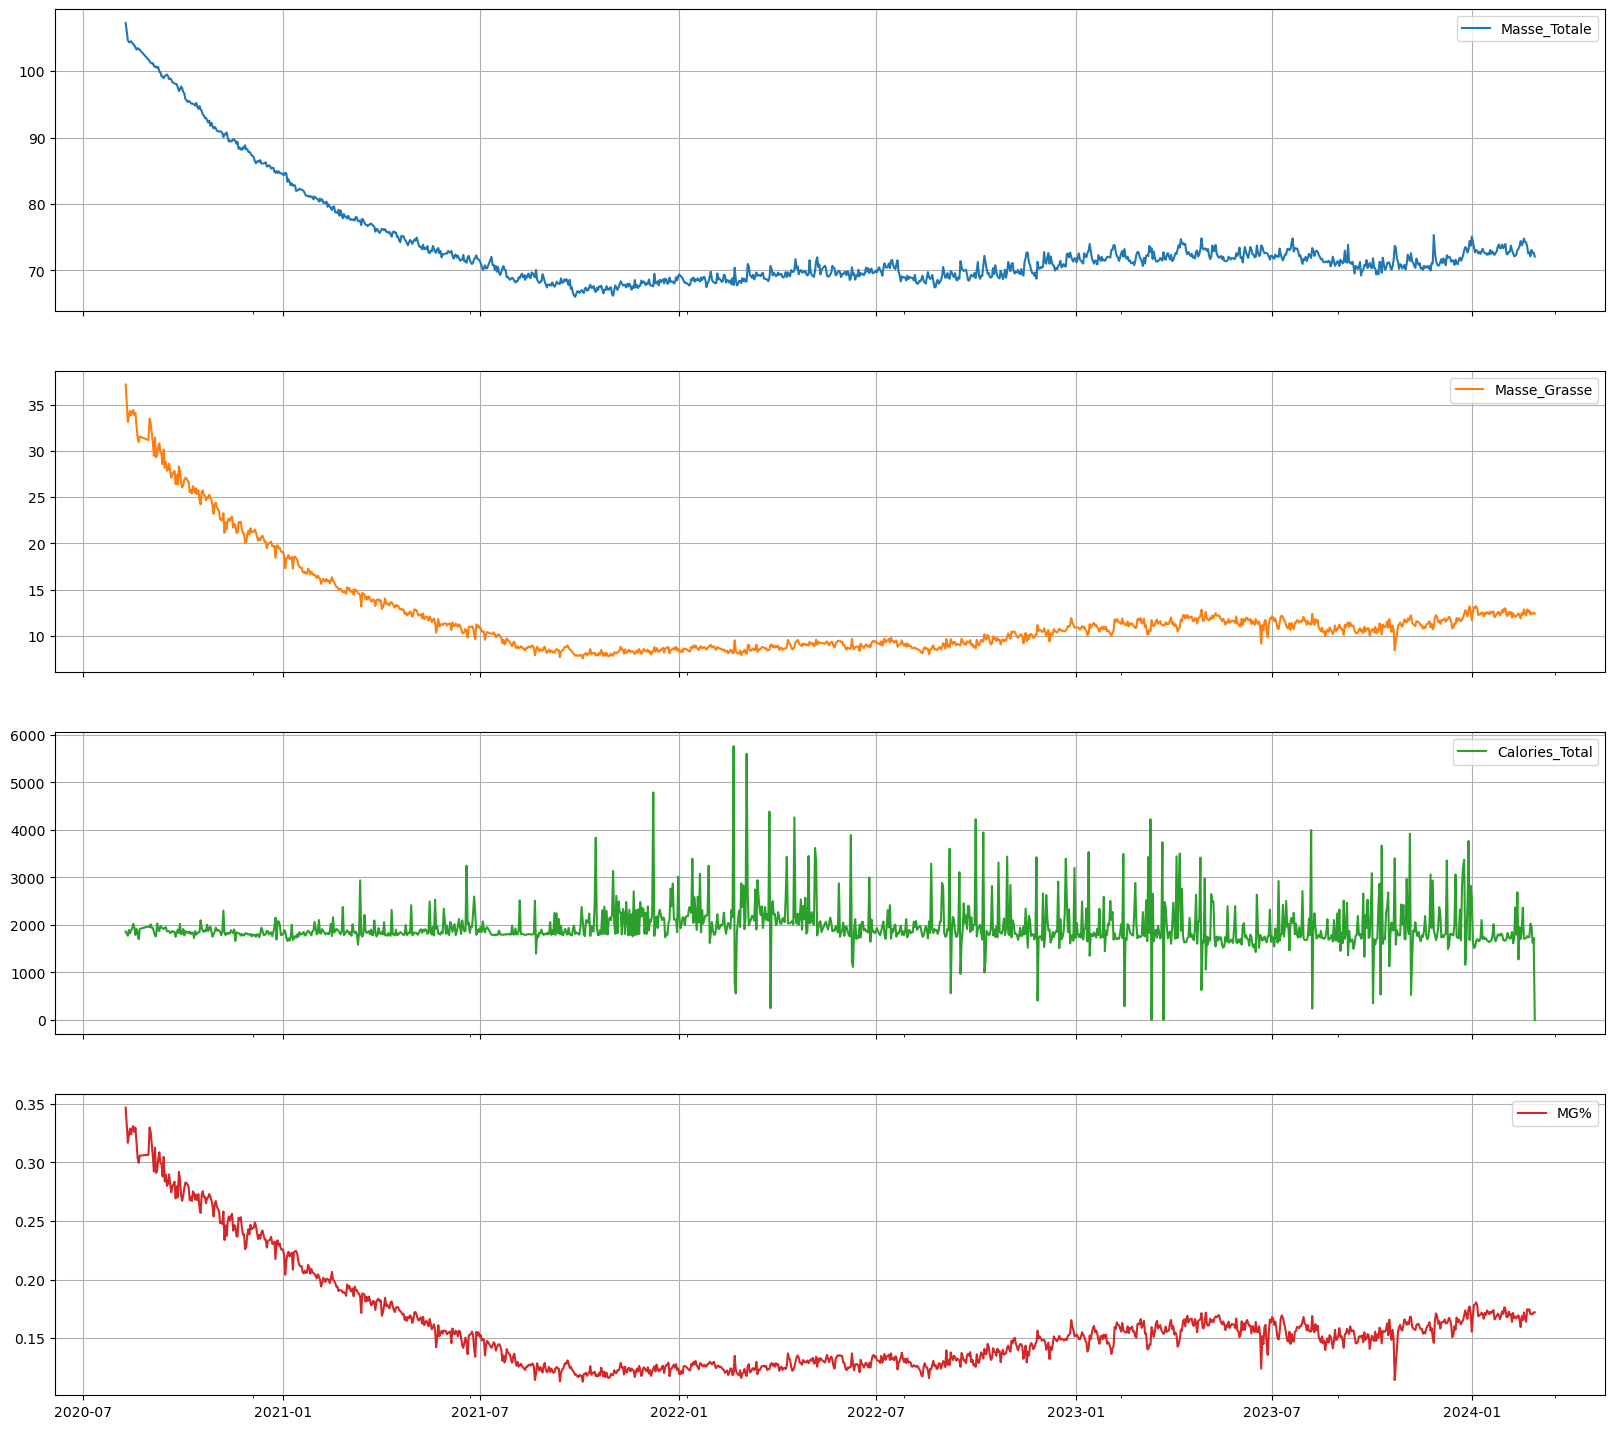

In [33]:
cols_to_display = ['Masse_Totale', 'Masse_Grasse', 'Calories_Total', 'MG%']

df_mtmg_only[cols_to_display].plot(subplots=True, figsize=(20,18), grid=True)
plt.show()

### Constitution du dataset pour training d'un premier modèle - masse totale et masse grasse seulement

In [81]:
PAST = 3 # jours dans le passé
FUTURE = 1 # nombre de jours prédiction dans le futur

L = len(df_mtmg_only)  # nombre de jours avec données MT et MG

In [117]:
df_mtmg_only.head(20)

,Masse_Totale,Masse_Grasse,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,Calories_Snacks,Lipides_Breakfast,Lipides_Dinner,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2020-08-09,107.250000,37.190000,0.346760,1883.296,683.1,504.7,615.5,58.0,25.0,30.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1861.3
2020-08-11,104.650000,33.150000,0.316770,1914.400,557.5,413.1,801.8,0.0,12.9,21.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1772.4
2020-08-12,104.350000,33.800000,0.323910,1893.880,690.1,563.3,640.9,0.0,25.0,13.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1894.3
2020-08-13,104.400000,34.340000,0.328927,1883.296,723.0,541.3,558.3,0.0,29.0,19.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1822.6
2020-08-14,104.500000,33.850000,0.323923,1896.040,723.0,637.9,530.6,0.0,29.0,27.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1891.5
2020-08-15,104.250000,34.280000,0.328825,1881.352,707.3,337.1,880.9,0.0,25.0,7.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1925.3
2020-08-16,104.050000,34.430000,0.330899,1873.792,743.4,572.5,705.8,0.0,29.1,25.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021.7
2020-08-17,103.900000,33.880000,0.326083,1882.432,702.6,702.8,541.1,0.0,28.9,17.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1946.5
2020-08-18,103.550000,34.130000,0.329599,1869.472,743.4,505.0,541.1,0.0,29.1,4.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1789.5
2020-08-19,103.250000,32.650000,0.316223,1894.960,743.4,528.1,643.3,0.0,29.1,17.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1914.8


In [83]:
columns = df_mtmg_only.columns

# data frame columns to be used as targets
Y_columns = ['Masse_Totale', 'Masse_Grasse']  

# data frame columns to be used as features
X_columns = ['Calories_Breakfast',
       'Calories_Dinner', 'Calories_Lunch', 'Calories_Snacks',
       # 'Lipides_Breakfast', 'Lipides_Dinner', 'Lipides_Lunch',
       # 'Lipides_Snacks', 'Glucides_Breakfast', 'Glucides_Dinner',
       # 'Glucides_Lunch', 'Glucides_Snacks', 'Proteines_Breakfast',
       # 'Proteines_Dinner', 'Proteines_Lunch', 'Proteines_Snacks',
       # 'BOXING_exo_duree', 'CROSS-COUNTRY_SKIING_exo_duree',
       # 'DOWNHILL_SKIING_exo_duree', 
       'INDOOR_ROWING_exo_duree',
       'JOGGING_exo_duree', 
       # 'ROWING_exo_duree', 
       'RUNNING_exo_duree',
       'STRENGTH_TRAINING_exo_duree', 
       # 'SWIMMING_exo_duree',
       # 'TREADMILL_RUNNING_exo_duree', 
       'WALKING_exo_duree',
       # 'BOXING_exo_cals_bruts', 'CROSS-COUNTRY_SKIING_exo_cals_bruts',
       # 'DOWNHILL_SKIING_exo_cals_bruts', 
       'INDOOR_ROWING_exo_cals_bruts',
       'JOGGING_exo_cals_bruts', 
       # 'ROWING_exo_cals_bruts',
       'RUNNING_exo_cals_bruts', 'STRENGTH_TRAINING_exo_cals_bruts',
       # 'SWIMMING_exo_cals_bruts', 'TREADMILL_RUNNING_exo_cals_bruts',
       'WALKING_exo_cals_bruts', 
       'Calories_Total'] 

# full_X_columns = ['Calories_Breakfast',
#        'Calories_Dinner', 'Calories_Lunch', 'Calories_Snacks',
#        'Lipides_Breakfast', 'Lipides_Dinner', 'Lipides_Lunch',
#        'Lipides_Snacks', 'Glucides_Breakfast', 'Glucides_Dinner',
#        'Glucides_Lunch', 'Glucides_Snacks', 'Proteines_Breakfast',
#        'Proteines_Dinner', 'Proteines_Lunch', 'Proteines_Snacks',
#        'BOXING_exo_duree', 'CROSS-COUNTRY_SKIING_exo_duree',
#        'DOWNHILL_SKIING_exo_duree', 'INDOOR_ROWING_exo_duree',
#        'JOGGING_exo_duree', 'ROWING_exo_duree', 'RUNNING_exo_duree',
#        'STRENGTH_TRAINING_exo_duree', 'SWIMMING_exo_duree',
#        'TREADMILL_RUNNING_exo_duree', 'WALKING_exo_duree',
#        'BOXING_exo_cals_bruts', 'C dropSTRENGTH_TRAINING_exo_cals_bruts',
#        'SWIMMING_exo_cals_bruts', 'TREADMILL_RUNNING_exo_cals_bruts',
#        'WALKING_exo_cals_bruts', 'Calories_Total'] # all features

In [111]:
class CreateDataset():
    """Create dataset for training, looking backward and forward
    """

    def __init__(
        self,
        df = None,
        past = None,
        future = None,
        target_columns = None,
        features_columns = None
    ):
        """
        Args:
            df (Dataframe, optional): Dataframe to use as souce. Defaults to df_mtmg_only.
            past (_type_, optional): number of days of past history to put in the features. Defaults to PAST.
            future (_type_, optional): numnber of days to use to create targets. Defaults to FUTURE.
            target_columns (_type_, optional): list of columns in df to use to create targets. Defaults to Y_columns. Typically mass values.
            features_columns (_type_, optional): list of columns in df to use as features. Defaults to X_columns. Typically food and exercices calories.
        """

        if df is None:
            self.df = df_mtmg_only
        else:
            self.df = df
            
        if past is None:
            self.past = PAST
        else:
            self.past = past
        
        if future is None:
            self.future = FUTURE
        else:
            self.future = future
            
        if target_columns is None:
            self.target_columns = Y_columns
        else:
            self.target_columns = target_columns
            
        if features_columns is None:
            self.features_columns = X_columns
        else:
            self.features_columns = features_columns
        
    def get_dataset(self):
        # prepare np.arrays to get features and targets
        timesteps = len(self.df) - self.future - self.past + 1 # number of time steps in total
        
        width_features_past = len(self.target_columns) + len(self.features_columns) # shape of the features block made of past mass and calories values
        widht_features_future = len(self.features_columns) # shape of the features block made of future calories values
        width_targets = len(self.target_columns) # shape of target blocks
        
        X_past = np.zeros(shape=(timesteps, self.past, width_features_past))
        X_future = np.zeros(shape=(timesteps, self.future-1, widht_features_future))
        y = np.zeros(shape=(timesteps, self.future, width_targets))
        
        # concatenate by past days and future days
        # 1/ row indexes in the dataframe df vary from 0 to len(df)-1 included
        # 2/ here, loop index J varies from PAST-1 to len(df)-1-FUTURE included
        # 3/ the block [J-PAST-1 to J] x [X_columns, Y_colums] is used as first part of features
        # 4/ the block [J+1 to J+FUTURE] x X_columns is used as second block of features
        # 5/ the block [J to J+FUTURE-1] x target_values_columns is used as target block
        
        for i, j in tqdm(enumerate(range(self.past-1, len(self.df)-self.future))):
            # print(f'i = {i}, j={j}')
            # assemble
            X_past[i] = self.df[self.target_columns + self.features_columns].iloc[j-self.past+1:j+1,:].to_numpy()
            X_future[i] = self.df[self.features_columns].iloc[j+1:j+self.future,:].to_numpy()
            y[i] = self.df[self.target_columns].iloc[j+1:j+self.future+1,:].to_numpy()
            
        return X_past, X_future, y
    
    def __repr__(self):
        representation = 'objet Create Dataset\n' + f'Dataset initial longueur {len(self.df)} jour(s)\n' + f'fenêtre PAST = {self.past} jour(s)\n' + f'fenêtre FUTURE = {self.future} jour(s)\n' 
        return representation

In [112]:
obj = CreateDataset(past=7, future=3)

print(obj)

objet Create Dataset
Dataset initial longueur 1282 jour(s)
fenêtre PAST = 7 jour(s)
fenêtre FUTURE = 3 jour(s)



In [113]:
X_past, X_future, y = obj.get_dataset()

1273it [00:22, 57.37it/s]


In [114]:
print(X_past.shape)
X_past[0]

(1273, 7, 17)


array([[ 107.25,   37.19,  683.1 ,  504.7 ,  615.5 ,   58.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  , 1861.3 ],
       [ 104.65,   33.15,  557.5 ,  413.1 ,  801.8 ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  , 1772.4 ],
       [ 104.35,   33.8 ,  690.1 ,  563.3 ,  640.9 ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  , 1894.3 ],
       [ 104.4 ,   34.34,  723.  ,  541.3 ,  558.3 ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  , 1822.6 ],
       [ 104.5 ,   33.85,  723.  ,  637.9 ,  530.6 ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  , 1891.5 ],
       [ 104.25,   34.28,  707.3 ,  337.1 ,  880.9 ,    0.  ,    0.  ,
           0.  ,    0.  ,    0.  ,    0

In [115]:
print(X_future.shape)
X_future[0]

(1273, 2, 15)


array([[ 702.6,  702.8,  541.1,    0. ,    0. ,    0. ,    0. ,    0. ,
           0. ,    0. ,    0. ,    0. ,    0. ,    0. , 1946.5],
       [ 743.4,  505. ,  541.1,    0. ,    0. ,    0. ,    0. ,    0. ,
           0. ,    0. ,    0. ,    0. ,    0. ,    0. , 1789.5]])

In [116]:
print(y.shape)
y[0]

(1273, 3, 2)


array([[103.9 ,  33.88],
       [103.55,  34.13],
       [103.25,  32.65]])